# Training, Engineering, and Model Assesment - FCN DL Model

## Import packages 

In [51]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# keras/tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import keras_tuner as kt
from tensorflow.keras.backend import clear_session


# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [ ]:
# set target (what are we trying to predict)
target = 'pwt_500hpa'
#target = 'temperature_800hpa'
# set lists of coordinates and time ranges (pulled from Prepare_AI_Ready_Data.py)
coords = [[180,240,45,65],[130,250,20,75]]
times = [['1970-01-01','2023-12-31']]  # Ensure the time range is valid

# set PC option - seperate or combined
#PC_option = 'combined'
PC_option = 'seperate'

# select which of the list I want to load
coords_num = 1
times_num = 0

# pull the correct coordinate and time (as set above)
c = coords[coords_num]
t = times[times_num]

# read in PCs
if PC_option == 'combined':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_combined_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')
elif PC_option == 'seperate':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_seperate_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')

# Keep only columns that are target, contain "PC", or contain "month"
#columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col or "month" in col]
columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col]
data = raw_data[columns_to_keep]

# normalize all input data to have values between 0 and 1, but keep as a df
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [53]:
# Prep data from ML

# Splitting the data into features X and label y
y = data[target].values  # e.g., binary classification label
X = data.drop(columns=[target]).values
# get names of features
feature_names = data.drop(columns=[target]).columns


# 70% training, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                  test_size=0.15, 
                                                  random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                  test_size=0.1765,  # 0.1765 of 0.85 ~ 0.15
                                                  random_state=42)

X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


## Hyperparameter Tuning

In [54]:
def build_fcn_model(hp):
    """
    Builds a Fully Convolutional Network for time-series regression.

    Args:
        hp (HyperParameters): Hyperparameter object from Keras Tuner

    Returns:
        A compiled Keras model.
    """

    model = keras.Sequential(name="fcn_regression")

    # -- 1) Conv Block 1 --------------------------------------------
    model.add(layers.Conv1D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5, 7]),
        padding='same',
        activation=None,  
        input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # -- 2) Conv Block 2 --------------------------------------------
    model.add(layers.Conv1D(
        filters=hp.Int('conv2_filters', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5, 7]),
        padding='same',
        activation=None
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # -- 3) Conv Block 3 --------------------------------------------
    model.add(layers.Conv1D(
        filters=hp.Int('conv3_filters', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv3_kernel_size', values=[3, 5, 7]),
        padding='same',
        activation=None
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # -- 4) Global Average Pooling ----------------------------------
    model.add(layers.GlobalAveragePooling1D())

    # -- 5) Optional Dropout after GAP ------------------------------
    if hp.Boolean('use_dropout'):
        model.add(layers.Dropout(
            rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        ))

    # -- 6) Output layer for regression -----------------------------
    model.add(layers.Dense(1, activation='linear'))

    # -- 7) Compile -------------------------------------------------
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mse']
    )

    return model



In [55]:
timesteps = X_train_cnn.shape[0]

tuner = kt.RandomSearch(
    build_fcn_model,
    objective="val_loss",             # or "val_mse", etc.
    max_trials=10,                    # number of different configs to try
    executions_per_trial=1,           # run each model once per trial
    directory="../data/my_tuner_dir",
    project_name="1d_fcn_regression"
)

# Incorporate Early Stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=3,
    restore_best_weights=True
)

In [56]:
t1 = time.perf_counter()
# Perform hyperparameter tuning
tuner.search(
    X_train, 
    y_train, 
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks = [early_stop]
)
t2 = time.perf_counter()
hyper_search_time = t2-t1

Trial 10 Complete [00h 00m 05s]
val_loss: 0.8003162741661072

Best val_loss So Far: 0.7932483553886414
Total elapsed time: 00h 00m 25s


In [57]:
# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# combine train + val data
X_train_val = np.concatenate((X_train_cnn, X_val_cnn), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Perform k-fold cross-validation
num_folds = 10  # Number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store the history and MSE for each fold
val_scores = []  # Store validation scores for each fold
histories = []  # Store training history for each fold
best_epochs = []

# Store MSE and  for each fold
fold_mse = []

t1 = time.perf_counter()
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"Training fold {fold + 1}/{num_folds}...")

    # Split data for this fold
    X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
    y_train_fold, y_val_fold = y_train_val[train_idx], y_train_val[val_idx]

    # Reinitialize model (since Keras models retain state)
    model = keras.models.clone_model(best_model)
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])

    # Train the model with early stopping
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=20,  # Adjust based on your needs
        batch_size=32,  # Adjust as needed
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop],
        verbose=0
    )
    
    # Store history for plotting
    histories.append(history.history)
    
    # Store the best epoch (length of training before early stopping)
    best_epochs.append(len(history.history['mse']))

    # Evaluate on validation set
    val_loss, val_mse = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_scores.append(val_mse)
    print(f"Fold {fold + 1} Validation MSE: {val_mse:.4f}")

t2 = time.perf_counter()
cv_time = t2 - t1

# Average performance across folds
avg_val_mse = np.mean(val_scores)
avg_best_epoch = int(np.mean(best_epochs))  # Compute average best epoch from k-fold training
print(f"Average Validation MSE: {avg_val_mse:.4f}")
print(f"Using {avg_best_epoch} epochs for final training.")

Training fold 1/10...
Fold 1 Validation MSE: 0.9533
Training fold 2/10...
Fold 2 Validation MSE: 0.8185
Training fold 3/10...
Fold 3 Validation MSE: 0.9718
Training fold 4/10...
Fold 4 Validation MSE: 0.8032
Training fold 5/10...
Fold 5 Validation MSE: 0.5913
Training fold 6/10...
Fold 6 Validation MSE: 0.7515
Training fold 7/10...
Fold 7 Validation MSE: 1.1701
Training fold 8/10...
Fold 8 Validation MSE: 0.7664
Training fold 9/10...
Fold 9 Validation MSE: 1.2641
Training fold 10/10...
Fold 10 Validation MSE: 1.3484
Average Validation MSE: 0.9439
Using 6 epochs for final training.


In [58]:
print("Best Hyperparameters:")
print(best_hps.values)
best_model.summary()

Best Hyperparameters:
{'conv1_filters': 112, 'conv1_kernel_size': 7, 'conv2_filters': 80, 'conv2_kernel_size': 7, 'conv3_filters': 16, 'conv3_kernel_size': 7, 'use_dropout': False, 'learning_rate': 0.001, 'dropout_rate': 0.5}
Model: "fcn_regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 30, 112)           896       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 112)          448       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 30, 112)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 30, 80)            62800     
                                                                 
 batch_normalization_4 (

# Plot Training and Validation MSE Across Folds

As with CNN, we see that the model is stopping early as the mse on the validation data blows up, due to overfitting on the training data and a lack of a real prediction.

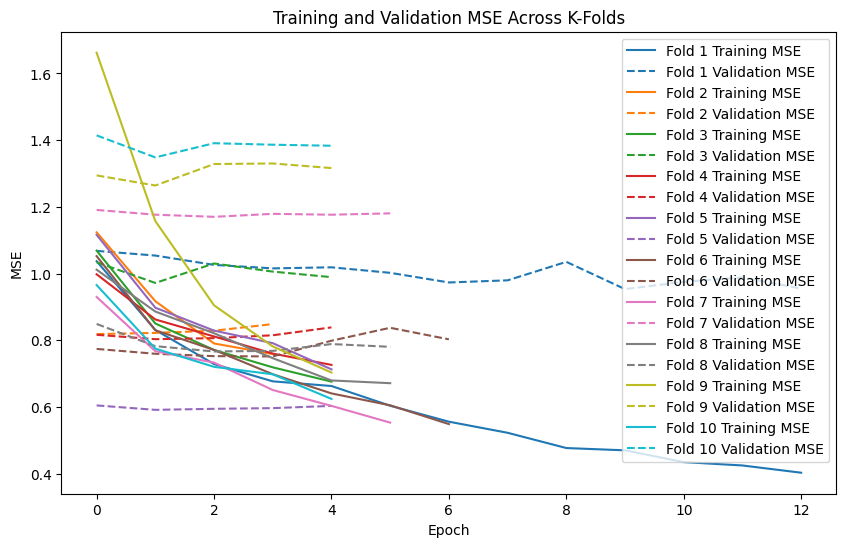

In [59]:
# ----------------- Plot Training and Validation MSE Across Folds -----------------
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Use a colormap for consistent colors

for i, history in enumerate(histories):
    plt.plot(history['mse'], label=f'Fold {i+1} Training MSE', color=colors[i % len(colors)])
    plt.plot(history['val_mse'], linestyle='--', label=f'Fold {i+1} Validation MSE', color=colors[i % len(colors)])

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training and Validation MSE Across K-Folds")
plt.legend()
plt.show()


## Final model training, with evaluation on test set

Note that here we cannot use early stopping, so instead we train to the average number of folds from the cross validation

In [60]:
from sklearn.metrics import r2_score

# Final Training on Full Train+Val Data 
print("Training final model on full train+val dataset...")

final_model = keras.models.clone_model(best_model)
final_model.compile(optimizer="adam", loss="mse", metrics=["mse"])
t1 = time.perf_counter()
final_model.fit(
    X_train_val, y_train_val,
    epochs=avg_best_epoch,  # Use the averaged best epoch
    batch_size=32,
    verbose=0
)
t2 = time.perf_counter()
print(f"Training time: {t2 - t1:.2f} seconds")

#  Final Evaluation on Test Set 
test_loss, test_mse = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test MSE: {test_mse:.4f}")
# Calculate R^2 score
r2 = r2_score(y_test, final_model.predict(X_test))
print(f"Final Test R^2: {r2:.4f}")

Training final model on full train+val dataset...
Training time: 1.95 seconds
3/3 [==============================] - 0s 3ms/step - loss: 1.0928 - mse: 1.0928
Final Test MSE: 1.0928
3/3 [==============================] - 0s 3ms/step
Final Test R^2: -0.0366


In [61]:
# Save the results from this run to a csv

results = pd.DataFrame(columns=['model', '1 Run Time', 'mean_squared_error','mean_r2','Hyperparameter Time','K-Fold Time'])
results = pd.concat([results, pd.DataFrame([{'model': 'FCN', '1 Run Time': t2-t1, 'mean_squared_error': test_mse, 'mean_r2': r2, 'Hyperparameter Time': hyper_search_time, 'K-Fold Time': cv_time }])], ignore_index=True)
results.to_csv(f'../data/results/fcn_results.csv', index=False)

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_59739/367705596.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'model': 'FCN', '1 Run Time': t2-t1, 'mean_squared_error': test_mse, 'mean_r2': r2, 'Hyperparameter Time': hyper_search_time, 'K-Fold Time': cv_time }])], ignore_index=True)
